# CNN avec des images personnalisées

Jusqu'à présent, tout ce avec quoi nous avons travaillé a déjà été bien formaté pour nous par Keras.

Voyons ce que cela donne de travailler avec un ensemble de données plus réaliste.

## Les données

--------
----------
--------

SOURCE DE DONNÉES ORIGINALE :

L'ensemble de données contient 2 dossiers - Infected - Uninfected

Et un total de 27 558 images.


Cet ensemble de données est extrait du site officiel du NIH : https://ceb.nlm.nih.gov/repositories/malaria-datasets/ 

**Note : Nous traiterons de vrais fichiers d'images, et NON de tableaux numérisés. Ce qui signifie qu'une grande partie de ce processus consistera à apprendre à travailler et à traiter de grands groupes de fichiers d'images. Il y a trop de données pour qu'elles tiennent en mémoire sous forme de tableau numérique, nous devrons donc les introduire par lots dans notre modèle. **

## Visualisation des données

-------
Examinons les données de plus près.

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [ ]:
# Téléchargement et extraction du fichier zip
import requests, zipfile, io
zip_file_url = 'https://moncoachdata.com/wp-content/uploads/cell_images.zip'
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [7]:
# Chemin d'accès du dossier cell_images
my_data_dir = 'cell_images'

In [8]:
# Confirmez que cela retourne 'test' et 'train'
os.listdir(my_data_dir) 

['test', 'train']

In [9]:
test_path = my_data_dir+'/test/'
train_path = my_data_dir+'/train/'

In [10]:
os.listdir(test_path)

['parasitized', 'uninfected']

In [11]:
os.listdir(train_path)

['parasitized', 'uninfected']

In [12]:
os.listdir(train_path+'parasitized')[0]

'C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [13]:
para_cell = train_path+'/parasitized'+'/C59P20thinF_IMG_20150803_113809_cell_41.png'

In [14]:
para_img = imread(para_cell)

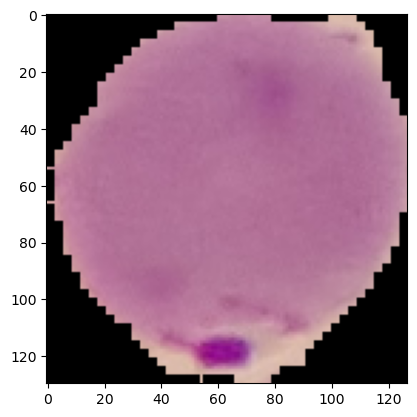

In [15]:
plt.imshow(para_img);

In [16]:
para_img.shape

(130, 127, 3)

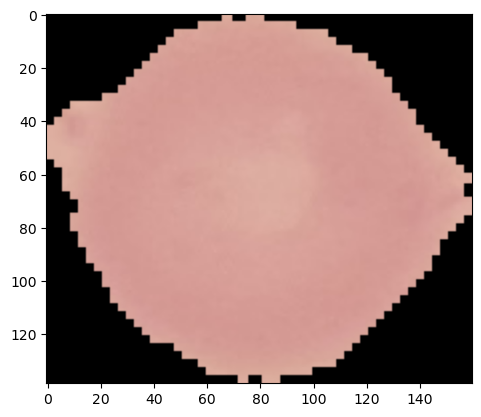

In [17]:
unifected_cell_path = train_path+'uninfected/'+os.listdir(train_path+'/uninfected')[0]
unifected_cell = imread(unifected_cell_path)
plt.imshow(unifected_cell);

**Vérifions combien d'images il y a.**

In [18]:
len(os.listdir(train_path+'parasitized'))

12480

In [19]:
len(os.listdir(train_path+'uninfected'))

12480

**Découvrons les dimensions moyennes de ces images.**

In [20]:
unifected_cell.shape

(139, 160, 3)

In [21]:
para_img.shape

(130, 127, 3)

In [22]:
# d'autres options : 
# https://stackoverflow.com/questions/1507084/how-to-check-dimensions-of-all-images-in-a-directory-using-python

dim1 = []
dim2 = []
for image_filename in os.listdir(test_path+'uninfected'):
    
    img = imread(test_path+'uninfected'+'/'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

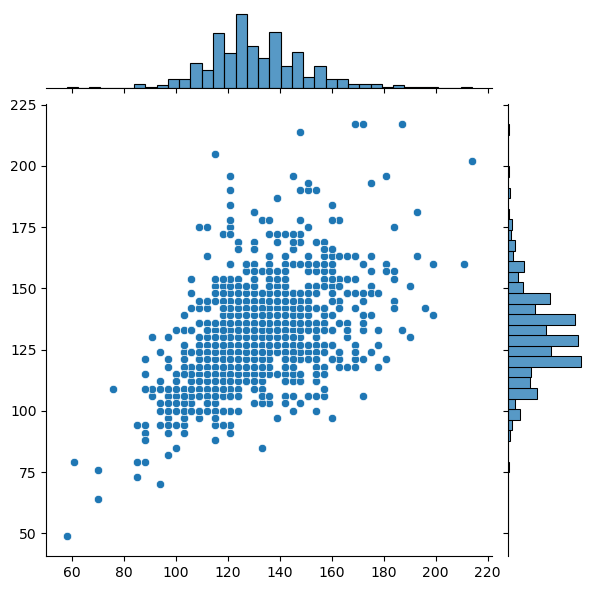

In [26]:
sns.jointplot(x=dim1,y=dim2)

In [25]:
np.mean(dim1)

130.92538461538462

In [27]:
np.mean(dim2)

130.75

In [28]:
image_shape = (130,130,3)

## Préparation des données pour le modèle

La mémoire contient trop de données pour que nous puissions les lire toutes en même temps. Nous pouvons utiliser certaines fonctions intégrées dans Keras pour traiter automatiquement les données, générer un flux de batches à partir d'un répertoire, et également manipuler les images.

### Manipulation des images

C'est généralement une bonne idée de manipuler les images avec une rotation, un redimensionnement et une mise à l'échelle afin que le modèle devienne plus robuste aux différentes images que notre ensemble de données n'a pas. Nous pouvons utiliser le générateur **ImageDataGenerator** pour le faire automatiquement pour nous. Consultez la documentation pour une liste complète de tous les paramètres que vous pouvez utiliser ici !

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [30]:
help(ImageDataGenerator)

Help on class ImageDataGenerator in module keras.preprocessing.image:

class ImageDataGenerator(builtins.object)
 |  ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format=None, validation_split=0.0, interpolation_order=1, dtype=None)
 |  
 |  Generate batches of tensor image data with real-time data augmentation.
 |  
 |  Deprecated: `tf.keras.preprocessing.image.ImageDataGenerator` is not
 |  recommended for new code. Prefer loading images with
 |  `tf.keras.utils.image_dataset_from_directory` and transforming the output
 |  `tf.data.Dataset` with preprocessing layers. For more informati

In [31]:
image_gen = ImageDataGenerator(rotation_range=20, # Faire pivoter l'image de 20 degrés
                               width_shift_range=0.10, # Modifier la largeur de la photo de 10% maximum
                               height_shift_range=0.10, # Modifier la hauteur de la photo de 10% maximum
                               # rescale=1/255, # Redimensionner l'image en la normalisant
                               shear_range=0.1, # shear signifie couper une partie de l'image (max 10%)
                               zoom_range=0.1, # Zoom de 10% maximum
                               horizontal_flip=True, # Autorise le basculement horizontal
                               fill_mode='nearest' # Remplir les pixels manquants avec la valeur remplie la plus proche
                              )

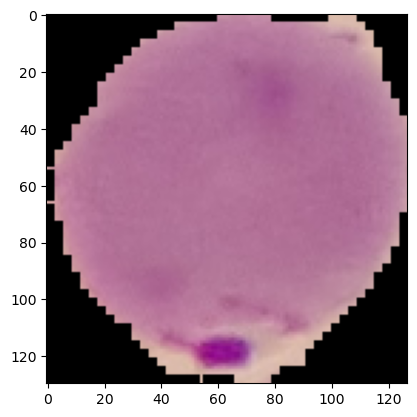

In [32]:
plt.imshow(para_img);

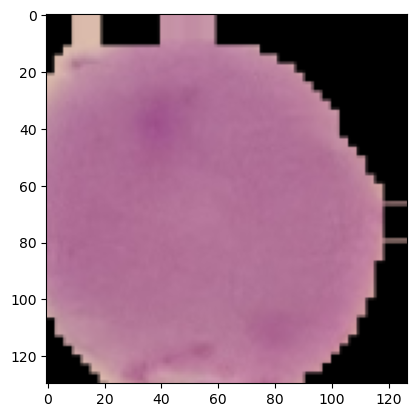

In [33]:
plt.imshow(image_gen.random_transform(para_img));

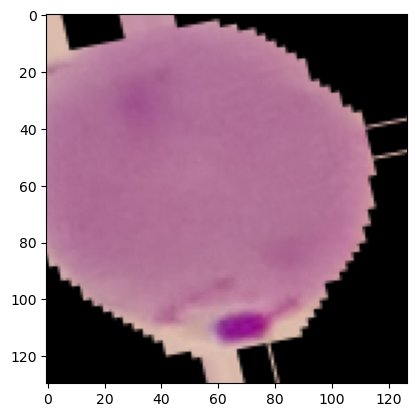

In [34]:
plt.imshow(image_gen.random_transform(para_img));

### Génération de nombreuses images manipulées à partir d'un répertoire


Pour utiliser .flow_from_directory, vous devez organiser les images dans des sous-répertoires. C'est une exigence absolue, sinon la méthode ne fonctionnera pas. Les répertoires ne doivent contenir que les images d'une seule classe, donc un dossier par classe d'images.

Structure nécessaire :

* Dossier de données d'images
    * Classe 1
        * 0.jpg
        * 1.jpg
        * …
    * Classe 2
        * 0.jpg
        * 1.jpg
        * …
    * …
    * Classe n

In [35]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [36]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


## Création du Modèle

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [38]:
#https://stats.stackexchange.com/questions/148139/rules-for-selecting-convolutional-neural-network-hyperparameters

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))

# Les couches Dropout aident à réduire l'overfitting en désactivant les neurones de façon aléatoire pendant l'entraînement.
# Ici nous demandons de désactiver aléatoirement 50% des neurones.
model.add(Dropout(0.5))

# Dernière couche, n'oubliez pas c'est binaire, nous utilisons donc la sigmoïde
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

### Early Stopping

In [40]:
from tensorflow.keras.callbacks import EarlyStopping

In [41]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

### Entraînement du Modèle

In [42]:
help(image_gen.flow_from_directory)

Help on method flow_from_directory in module keras.preprocessing.image:

flow_from_directory(directory, target_size=(256, 256), color_mode='rgb', classes=None, class_mode='categorical', batch_size=32, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='png', follow_links=False, subset=None, interpolation='nearest', keep_aspect_ratio=False) method of keras.preprocessing.image.ImageDataGenerator instance
    Takes the path to a directory & generates batches of augmented data.
    
    Args:
        directory: string, path to the target directory. It should contain one
          subdirectory per class. Any PNG, JPG, BMP, PPM or TIF images inside
          each of the subdirectories directory tree will be included in the
          generator. See [this script](
            https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d)
              for more details.
        target_size: Tuple of integers `(height, width)`, defaults to `(256,
          256)`. The dime

In [43]:
batch_size = 16

In [44]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 24958 images belonging to 2 classes.


In [45]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 2600 images belonging to 2 classes.


In [46]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [47]:
results = model.fit(train_image_gen,epochs=20,
                              validation_data=test_image_gen,
                             callbacks=[early_stop])

Epoch 1/20
1560/1560 [==============================] - 451s 288ms/step - loss: 0.8950 - accuracy: 0.5409 - val_loss: 0.6781 - val_accuracy: 0.5750
Epoch 2/20
1560/1560 [==============================] - 433s 277ms/step - loss: 0.6829 - accuracy: 0.5682 - val_loss: 0.6755 - val_accuracy: 0.5765
Epoch 3/20
1560/1560 [==============================] - 474s 303ms/step - loss: 0.6746 - accuracy: 0.5907 - val_loss: 0.6670 - val_accuracy: 0.5973
Epoch 4/20
1560/1560 [==============================] - 414s 265ms/step - loss: 0.6722 - accuracy: 0.5920 - val_loss: 0.6695 - val_accuracy: 0.6004
Epoch 5/20
1560/1560 [==============================] - 467s 299ms/step - loss: 0.6677 - accuracy: 0.6062 - val_loss: 0.6648 - val_accuracy: 0.6058
Epoch 6/20
1560/1560 [==============================] - 502s 322ms/step - loss: 0.2998 - accuracy: 0.8881 - val_loss: 0.1927 - val_accuracy: 0.9423
Epoch 7/20
1560/1560 [==============================] - 463s 297ms/step - loss: 0.1948 - accuracy: 0.9419 - val_

In [48]:
from tensorflow.keras.models import load_model
model.save('malaria_detector.h5')

## Évaluation du Modèle

In [49]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

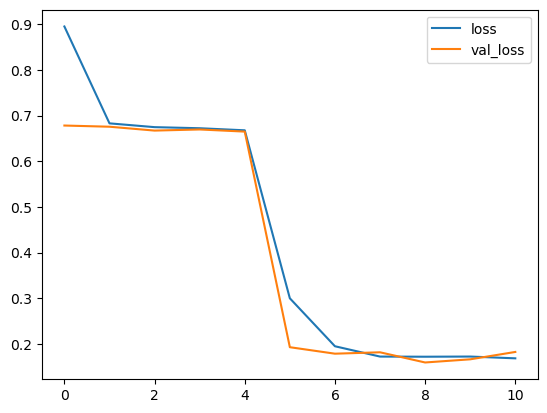

In [50]:
losses[['loss','val_loss']].plot()

In [51]:
model.metrics_names

['loss', 'accuracy']

In [52]:
model.evaluate(test_image_gen)

163/163 [==============================] - 23s 143ms/step - loss: 0.1815 - accuracy: 0.9438


[0.1814883053302765, 0.9438461661338806]

In [53]:
from tensorflow.keras.preprocessing import image

In [54]:
# https://datascience.stackexchange.com/questions/13894/how-to-get-predictions-with-predict-generator-on-streaming-test-data-in-keras

pred_probabilities = model.predict(test_image_gen)

163/163 [==============================] - 24s 148ms/step


In [55]:
pred_probabilities

array([[2.5833675e-04],
       [8.1823062e-05],
       [4.1966309e-04],
       ...,
       [9.4419271e-01],
       [8.9836049e-01],
       [9.3560535e-01]], dtype=float32)

In [56]:
test_image_gen.classes

array([0, 0, 0, ..., 1, 1, 1])

In [57]:
predictions = pred_probabilities > 0.5

In [58]:
# Numpy peut traiter cela comme True/False pour nous

predictions

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [59]:
from sklearn.metrics import classification_report,confusion_matrix

In [60]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1300
           1       0.92      0.96      0.94      1300

    accuracy                           0.94      2600
   macro avg       0.94      0.94      0.94      2600
weighted avg       0.94      0.94      0.94      2600



In [61]:
confusion_matrix(test_image_gen.classes,predictions)

array([[1195,  105],
       [  53, 1247]], dtype=int64)

## Prédiction sur une image

In [62]:
para_cell

'cell_images/train//parasitized/C59P20thinF_IMG_20150803_113809_cell_41.png'

In [63]:
my_image = image.load_img(para_cell,target_size=image_shape)

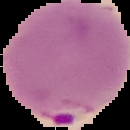

In [64]:
my_image

In [65]:
type(my_image)

PIL.Image.Image

In [66]:
my_image = image.img_to_array(my_image)

In [67]:
type(my_image)

numpy.ndarray

In [68]:
my_image.shape

(130, 130, 3)

In [69]:
my_image = np.expand_dims(my_image, axis=0)

In [70]:
my_image.shape

(1, 130, 130, 3)

In [71]:
(model.predict(my_image) > 0.5).astype('int32')

1/1 [==============================] - 0s 191ms/step


array([[0]])

In [72]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [73]:
test_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}